In [52]:
%pwd

u'/home/ubuntu/nbs/data/redux'

In [51]:
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
print(current_dir)

/home/ubuntu/nbs/data/redux


In [10]:
data_dir = current_dir + '/data/redux'

from utils import *
from vgg16 import Vgg16

%matplotlib inline

In [11]:
%cd $data_dir

/home/ubuntu/nbs/data/redux


In [12]:
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

In [13]:
%cd $data_dir/train

/home/ubuntu/nbs/data/redux/train


In [14]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], data_dir+'/valid/' + shuf[i])

In [15]:
from shutil import copyfile

In [16]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], data_dir+'/sample/train/' + shuf[i])

In [17]:
%cd $data_dir/valid

/home/ubuntu/nbs/data/redux/valid


In [18]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], data_dir+'/sample/valid/' + shuf[i])

In [19]:
%cd $data_dir/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $data_dir/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $data_dir/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $data_dir/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/nbs/data/redux/sample/train
/home/ubuntu/nbs/data/redux/sample/valid
/home/ubuntu/nbs/data/redux/valid
/home/ubuntu/nbs/data/redux/train


In [20]:
# Create single 'unknown' class for test set
%cd $data_dir/test
%mv *.jpg unknown/

/home/ubuntu/nbs/data/redux/test


In [21]:
%cd $data_dir

/home/ubuntu/nbs/data/redux


In [22]:
#Set path to sample/ path if desired
path = data_dir + '/' #'/sample/'
test_path = data_dir + '/test/' #We use all the test data
results_path=data_dir + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

In [23]:
vgg = Vgg16()

In [29]:
batch_size = 64
no_of_epochs = 3

In [30]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.01

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [31]:
latest_weights_filename = None
for epoch in range(no_of_epochs):
#     print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
# print "Completed %s fit operations" % no_of_epochs

Epoch 1/1
23000/23000 [==============================] - 632s - loss: 0.3680 - acc: 0.9686 - val_loss: 0.2399 - val_acc: 0.9815
Epoch 1/1
23000/23000 [==============================] - 635s - loss: 0.3212 - acc: 0.9767 - val_loss: 0.2175 - val_acc: 0.9840
Epoch 1/1
23000/23000 [==============================] - 634s - loss: 0.3218 - acc: 0.9779 - val_loss: 0.2585 - val_acc: 0.9825


In [34]:
batches, preds = vgg.test(test_path, batch_size=batch_size*2)

# For every image, vgg.test() generates two probabilities
# based on how cats/dogs directories are ordered.

print(preds[:5])

filenames = batches.filenames
print(filenames[:5])

Found 12500 images belonging to 1 classes.
[[  1.0000e+00   0.0000e+00]
 [  1.0000e+00   2.1079e-38]
 [  1.0000e+00   0.0000e+00]
 [  1.0000e+00   0.0000e+00]
 [  0.0000e+00   1.0000e+00]]
['unknown/9292.jpg', 'unknown/12026.jpg', 'unknown/9688.jpg', 'unknown/4392.jpg', 'unknown/779.jpg']


In [36]:
save_array(results_path+'test_preds.dat', preds)
save_array(results_path+'filenames.dat', filenames)

In [37]:
vgg.model.load_weights(results_path+latest_weights_filename)
print(latest_weights_filename)

ft2.h5


In [38]:
val_batches, probs = vgg.test(valid_path, batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [39]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[996  12]
 [ 25 967]]


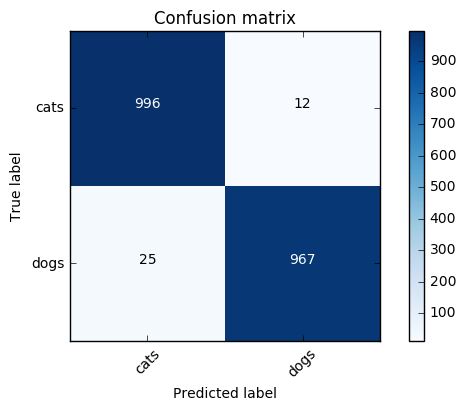

In [41]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [42]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [44]:
# Grab the dog prediction column
isdog = preds[:,1]
print("Raw Predictions: " + str(isdog[:5]))
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [  0.0000e+00   2.1079e-38   0.0000e+00   0.0000e+00   1.0000e+00]
Mid Predictions: []
Edge Predictions: [ 0.  0.  0. ...,  0.  0.  1.]


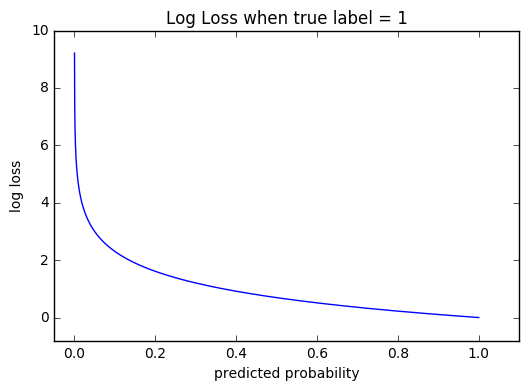

In [45]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss

x = [i*.0001 for i in range(1,10000)]
y = [log_loss([1],[[i*.0001,1-(i*.0001)]],eps=1e-15) for i in range(1,10000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [46]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
isdog = isdog.clip(min=0.05, max=0.95)

In [47]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [48]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  9.2920e+03,   5.0000e-02],
       [  1.2026e+04,   5.0000e-02],
       [  9.6880e+03,   5.0000e-02],
       [  4.3920e+03,   5.0000e-02],
       [  7.7900e+02,   9.5000e-01]])

In [49]:
%cd $data_dir
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/nbs/data/redux


In [55]:
from IPython.display import FileLink
%cd $LESSON_HOME_DIR
FileLink(data_dir+'/'+submission_file_name)

/home/ubuntu/nbs/data/redux


/home/ubuntu/nbs/data/redux/submission1.csv